# Wikibook title and text generation using LSTM

Created by Nicholas Felcher

Github: https://github.com/NicholasFelcher/CISB63_Final

Dataset: https://www.kaggle.com/datasets/dhruvildave/wikibooks-dataset/

## Import required libraries

In [286]:
#data visualization
import pandas as pd
import numpy as np
import string
import os
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt


#warnings
import warnings
warnings.filterwarnings("ignore")

#database retrieval
import sqlite3

#nltk, stemmers, spacy, regex
import nltk
import spacy
import re

#LSTM, deep learning 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku 

In [3]:
#connect to the database
conn = sqlite3.connect('wikibooks.sqlite')
df = pd.read_sql_query("SELECT * FROM en", conn)

In [4]:
conn.close()

# EDA

In [5]:
df.head()

,title,url,abstract,body_text,body_html
0,Wikibooks: Radiation Oncology/NHL/CLL-SLL,https://en.wikibooks.org/wiki/Radiation_Oncolo...,Chronic Lymphocytic Leukemia and Small Lymphoc...,Front Page: Radiation Oncology | RTOG Trials |...,"<div class=""mw-parser-output""><table width=""10..."
1,Wikibooks: Romanian/Lesson 9,https://en.wikibooks.org/wiki/Romanian/Lesson_9,==Băuturi/Beverages==,Băuturi/Beverages[edit | edit source]\nTea : C...,"<div class=""mw-parser-output""><h2><span id=""B...."
2,Wikibooks: Karrigell,https://en.wikibooks.org/wiki/Karrigell,Karrigell is an open Source Python web framewo...,Karrigell is an open Source Python web framewo...,"<div class=""mw-parser-output""><p>Karrigell is ..."
3,Wikibooks: The Pyrogenesis Engine/0 A.D./GuiSe...,https://en.wikibooks.org/wiki/The_Pyrogenesis_...,====setupUnitPanel====,setupUnitPanel[edit | edit source]\nHelper fun...,"<div class=""mw-parser-output""><h4><span class=..."
4,Wikibooks: LMIs in Control/pages/Exterior Coni...,https://en.wikibooks.org/wiki/LMIs_in_Control/...,== The Concept ==,Contents\n\n1 The Concept\n2 The System\n3 The...,"<div class=""mw-parser-output""><div id=""toc"" cl..."


In [6]:
df.describe()

,title,url,abstract,body_text,body_html
count,86736,86736,86736,86736,86736
unique,86736,86736,62141,85318,86736
top,Wikibooks: Radiation Oncology/NHL/CLL-SLL,https://en.wikibooks.org/wiki/Radiation_Oncolo...,,Annotations[edit | edit source]\nReferences[ed...,"<div class=""mw-parser-output""><table width=""10..."
freq,1,1,2130,362,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86736 entries, 0 to 86735
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      86736 non-null  object
 1   url        86736 non-null  object
 2   abstract   86736 non-null  object
 3   body_text  86736 non-null  object
 4   body_html  86736 non-null  object
dtypes: object(5)
memory usage: 3.3+ MB


**No null values, so cleaning is easy**

## Cleaning/Preprocessing Titles

In [8]:
df['title'][3]

'Wikibooks: The Pyrogenesis Engine/0 A.D./GuiSession'

In [9]:
nlp = spacy.load('en_core_web_sm')
#cleans the titles by removing constant elements, punctuation, uppercase words, and stopwords.
def clean_title(txt, stem="None"):
    final_string = ""
    #Remove the Constant element in each title
    txt = txt.replace('Wikibooks: ' ,'')
    #remove uppercase
    txt = txt.lower()
    #remove punctuation
    for i in string.punctuation:
        txt = txt.replace(i ,' ')
    #split txt
    txt = txt.split()
    #retrieve list of stopwords
    stop_words = nltk.corpus.stopwords.words("english")
    text_filtered = [word for word in txt if not word in stop_words]

    final_string = ' '.join(text_filtered)
    return final_string

In [10]:
df['title_clean'] = df['title'].apply(lambda x: clean_title(x))

In [95]:
df['title_clean'].head()

0                    radiation oncology nhl cll sll
1                                 romanian lesson 9
2                                         karrigell
3                   pyrogenesis engine 0 guisession
4    lmis control pages exterior conic sector lemma
Name: title_clean, dtype: object

In [276]:
#turn dataframe into one large corpus (list)
corpus = []
for i in df['title_clean'][0:8000]:
    corpus.append(i)

**WordCloud Visualization for Titles**

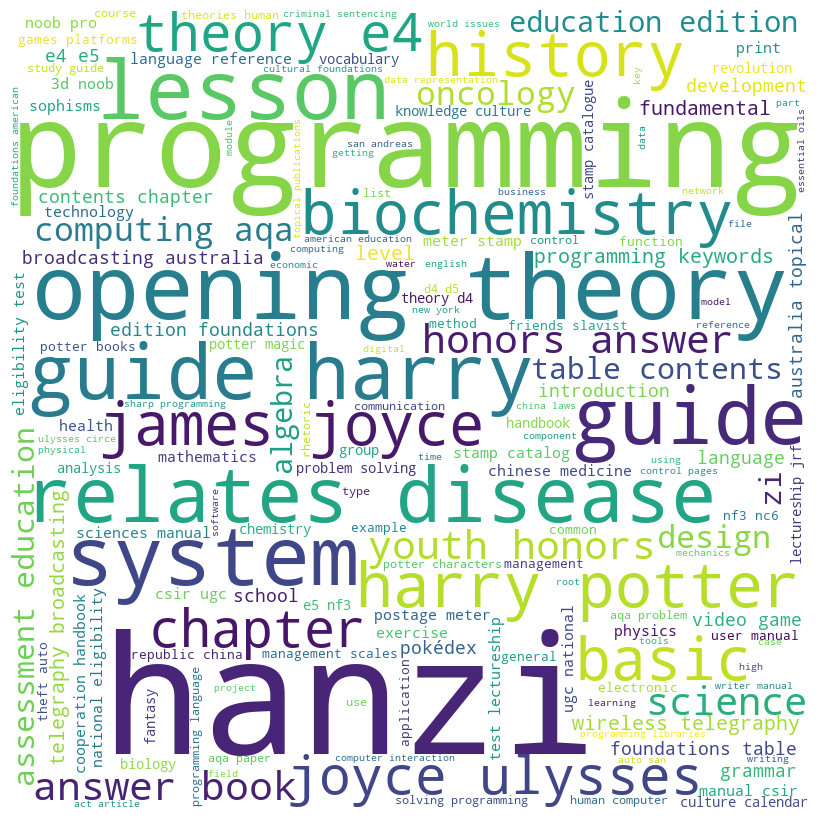

In [287]:
#titles wordcloud
word_string = ''
for i in corpus:
    word_string += i
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(word_string)
 
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

## Creating tokens

Using keras.tokenizer I separated words into tokens. This transforms each word into a numerical value so I can create a padded sequence. I then feed the padded sequences into a LSTM model

In [13]:
tokenizer = Tokenizer()

def get_sequence_of_tokens(corpus):
    ## tokenization
    tokenizer.fit_on_texts(corpus)
    total_words = len(tokenizer.word_index) + 1
    
    ## convert corpus to sequence of tokens 
    input_sequences = []
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)
    return input_sequences, total_words

inp_sequences, total_words = get_sequence_of_tokens(corpus)
inp_sequences[:20]

[[38, 55],
 [38, 55, 2148],
 [38, 55, 2148, 4140],
 [38, 55, 2148, 4140, 4141],
 [2149, 41],
 [2149, 41, 138],
 [4142, 705],
 [4142, 705, 450],
 [4142, 705, 450, 4143],
 [173, 73],
 [173, 73, 214],
 [173, 73, 214, 2804],
 [173, 73, 214, 2804, 4144],
 [173, 73, 214, 2804, 4144, 4145],
 [173, 73, 214, 2804, 4144, 4145, 950],
 [844, 27],
 [844, 27, 160],
 [844, 27, 160, 2805],
 [844, 27, 160, 2805, 4146],
 [844, 27, 160, 2805, 4146, 4147]]

In [14]:
def generate_padded_sequences(input_sequences):
    max_sequence_len = max([len(x) for x in input_sequences])
    input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
    
    predictors, label = input_sequences[:,:-1],input_sequences[:,-1]
    label = ku.to_categorical(label, num_classes=total_words)
    return predictors, label, max_sequence_len

predictors, label, max_sequence_len = generate_padded_sequences(inp_sequences)

# LSTM Neural Network

I'm using a LSTM recurrent neural network to train my model. LSTM's are great for generative and predictive model.

My first layer is an embedded layer, this is to to transform the higher-dimentional data (arrays of text) into a lower-dementional format for the LSTM

I then have a hidden LSTM layer with the unit parameter at 100, followed by a dropout of 10%

Finally I have my output layer which is just a softmax dense layer

I compiled my model with the adam optimizer and a loss functino of categorical crossentropy

In [15]:
def create_model(max_sequence_len, total_words):
    input_len = max_sequence_len - 1
    model = Sequential()
    
    #embedding layer as input
    model.add(Embedding(total_words, 10, input_length=input_len))
    
    #1 hidden lstm layer with 10% dropout
    model.add(LSTM(100))
    model.add(Dropout(0.1))
    
    #output layer
    model.add(Dense(total_words, activation='softmax'))
    
    #compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    return model

model = create_model(max_sequence_len, total_words)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 44, 10)            93080     
                                                                 
 lstm (LSTM)                 (None, 100)               44400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 9308)              940108    
                                                                 
Total params: 1077588 (4.11 MB)
Trainable params: 1077588 (4.11 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
model.fit(predictors, label, epochs=100, verbose=3)

Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100
Epoch 59/100
Epoch 60/100
Epoch 61/100
Epoch 62/100
Epoch 63/100
Epoch 64/100
Epoch 65/100
Epoch 66/100
Epoch 67/100
Epoch 68/100
Epoch 69/100
Epoch 70/100
Epoch 71/100
Epoch 72/100
Epoch 73/100
Epoch 74/100
Epoch 75/100
Epoch 76/100
Epoch 77/100
Epoch 78

**Save the model**

In [17]:
model.save('titles2.keras')

# Predicting Titles

In [23]:
def generate_title(input_text, next_words, model, max_sequence_len):
    for _ in range(next_words):
        #creates a list of tokens
        token_list = tokenizer.texts_to_sequences([input_text])[0]
        #creates a padded sequence from the list of tokens
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        #predict the next word
        predicted = np.argmax(model.predict(token_list),axis=1)
        
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                #add predicted text to output
                output_word = word
                break
        input_text += " "+output_word
    return 'Wikibooks: '+ input_text.title()

Some cherrypicked examples

In [25]:
generate_title('Science', 3, model, max_sequence_len)

1/1 [==============================] - 0s 13ms/step


'Wikibooks: Science Elementary Teacher’S Guide'

In [26]:
generate_title('Chess', 4, model, max_sequence_len)

1/1 [==============================] - 0s 13ms/step


'Wikibooks: Chess Opening Theory 1 E4'

In [27]:
generate_title('The', 4, model, max_sequence_len)

1/1 [==============================] - 0s 12ms/step


'Wikibooks: The Programming Fundamentals Condition Examples'

In [28]:
generate_title('Python', 6, model, max_sequence_len)

1/1 [==============================] - 0s 14ms/step


'Wikibooks: Python Programming Gui Programming Data Configuration Configuration'

In [33]:
generate_title('Bob', 3, model, max_sequence_len)

1/1 [==============================] - 0s 12ms/step


'Wikibooks: Bob Shakespeare Works Comedies'

In [37]:
generate_title('A collection of', 4, model, max_sequence_len)

1/1 [==============================] - 0s 12ms/step


'Wikibooks: A Collection Of Programming Code Statements Control'

## Cleaning/Preprocessing book body

In [115]:
#an example of a text body
df['body_text'][11]

'This Wikibooks page is a fact sheet and analysis on the article "Habitual physical activity in children and adolescents with cystic fibrosis" about how exercise is related to the disease Cystic Fibrosis.\n\nContents\n\n1 Background of this research\n2 Where is the research from\xa0?\n3 What kind of research was this?\n4 What did the research involve?\n\n4.1 Pulmonary Function testing\n4.2 Pros / Cons of this test\n\n\n5 What were the basic results?\n6 What conclusion can we take from this research\xa0?\n7 Practical Advice\n8 Further information/ Resources\n\n8.1 Cystic Fibrosis Australia\n8.2 Cystic Fibrosis\'s National Ambassador Nathan Charles\n\n\n9 References\n\n\n\nBackground of this research[edit\xa0| edit source]\nThe research was about the effects of taking part in exercise constantly or making it a habit in the population of children and teens that are severing from the genetic condition cystic Fibrosis.\nWhat is  Cystic Fibrosis\nIt is a genetic condition, affecting lungs an

In [193]:
#creating my own punctuation list, i'm allowing the apostrophy to let contractions like don't to stay as one word
punctuation = string.punctuation.replace("'",'')
punctuation

'!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~'

In [202]:
#function to clean text by removing punctuation, numbers, and irrelevant text.
nlp = spacy.load('en_core_web_sm')
def clean_body(txt, stem="None"):
    final_string = ""
    #remove uppercase
    txt = txt.lower()
    #remove line breaks
    txt = re.sub(r'\n', ' ', txt)
    #remove left in website text (only sometimes works?)
    txt = txt.replace('[edit\xa0| edit source]', ' ')
    #remove numbers
    txt = re.sub('[\d-]', ' ',txt)
    #remove unicode
    txt = re.sub(r'[^\x00-\x7F]', ' ', txt)
    #remove punctuation
    for i in punctuation:
        txt = txt.replace(i ,' ')
    #removes stray letters (leftover from punctuation being cleaned)
    #i put this multiple times because if two single letters were separated by a space it would only remove one of them
    txt = re.sub("(^| ).( |$)", ' ', txt)
    txt = re.sub("(^| ).( |$)", ' ', txt)
    txt = re.sub("(^| ).( |$)", ' ', txt)
    #split txt
    txt = txt.split()
    
    #retrieve list of stopwords
    stop_words = nltk.corpus.stopwords.words("english")
    text_filtered = [word for word in txt if not word in stop_words]

    final_string = ' '.join(text_filtered)
    return final_string

In [203]:
df['body_clean'] = df['body_text'].apply(lambda x: clean_body(x))

In [204]:
#look at same example cleaned
df['body_clean'][11]

"wikibooks page fact sheet analysis article habitual physical activity children adolescents cystic fibrosis exercise related disease cystic fibrosis contents background research research kind research research involve pulmonary function testing pros cons test basic results conclusion take research practical advice information resources cystic fibrosis australia cystic fibrosis's national ambassador nathan charles references background research research effects taking part exercise constantly making habit population children teens severing genetic condition cystic fibrosis cystic fibrosis genetic condition affecting lungs digestion unfortunately cure condition cystic fibrosis cf mostly inherited white population every live births diagnosed condition research research based american children hospital pittsburgh cf centre volunteers research included siblings friends hospital employee children condition two authors research work within department paediatrics others conducted research rega

**Create Tokens**

Tokenization, padded sequences, and model creation functions were already defined when working with the titles

In [288]:
corpus = []
#only take the first 800 results becasue of memory problems
for i in df['body_clean'][0:900]:
    wordlist = i.split()
    #only take 100 words because of memory problems
    corpus.append(i[10:110])

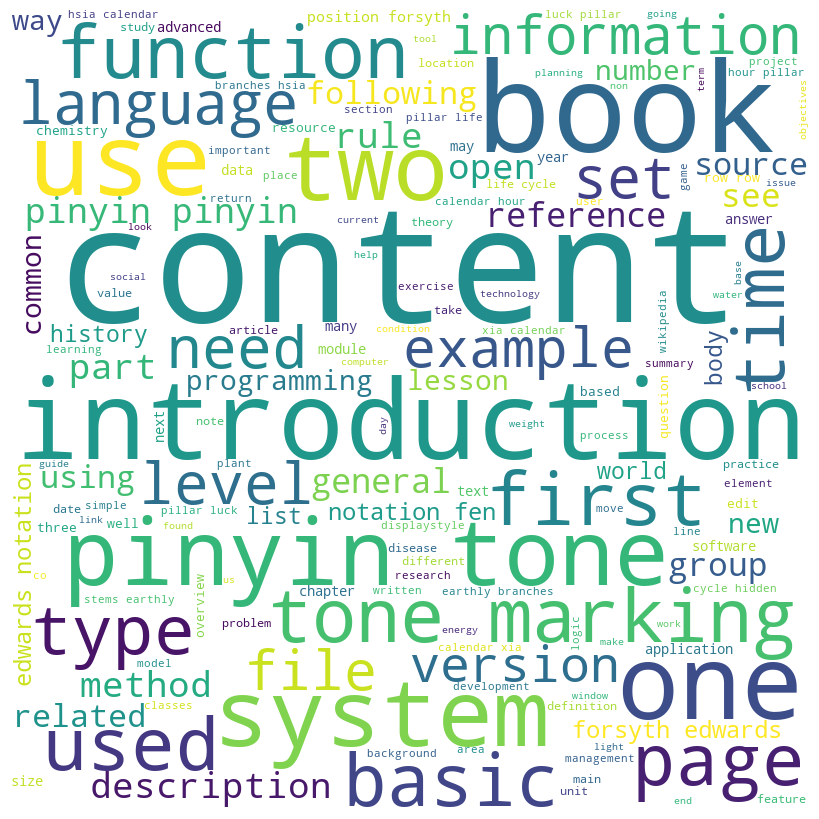

In [289]:
#body wordcloud
word_string = ''
for i in corpus:
    word_string += i
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(word_string)
 
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

In [251]:
inp_sequences, total_words = get_sequence_of_tokens(corpus)
inp_sequences[:20]

[[931, 1876],
 [931, 1876, 3211],
 [931, 1876, 3211, 1288],
 [931, 1876, 3211, 1288, 1675],
 [931, 1876, 3211, 1288, 1675, 1288],
 [931, 1876, 3211, 1288, 1675, 1288, 263],
 [931, 1876, 3211, 1288, 1675, 1288, 263, 12072],
 [931, 1876, 3211, 1288, 1675, 1288, 263, 12072, 6619],
 [931, 1876, 3211, 1288, 1675, 1288, 263, 12072, 6619, 154],
 [931, 1876, 3211, 1288, 1675, 1288, 263, 12072, 6619, 154, 43],
 [931, 1876, 3211, 1288, 1675, 1288, 263, 12072, 6619, 154, 43, 1675],
 [931, 1876, 3211, 1288, 1675, 1288, 263, 12072, 6619, 154, 43, 1675, 402],
 [33503, 1017],
 [33503, 1017, 12074],
 [33503, 1017, 12074, 4957],
 [33503, 1017, 12074, 4957, 12075],
 [33503, 1017, 12074, 4957, 12075, 64],
 [33503, 1017, 12074, 4957, 12075, 64, 5717],
 [33503, 1017, 12074, 4957, 12075, 64, 5717, 9982],
 [33503, 1017, 12074, 4957, 12075, 64, 5717, 9982, 197]]

**Create padded seqence**

In [252]:
predictors, label, max_sequence_len_body = generate_padded_sequences(inp_sequences)

**Create LSTM model for body**

In [253]:
model_body = create_model(max_sequence_len_body, total_words)
model_body.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 22, 10)            654870    
                                                                 
 lstm_5 (LSTM)               (None, 100)               44400     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_5 (Dense)             (None, 65487)             6614187   
                                                                 
Total params: 7313457 (27.90 MB)
Trainable params: 7313457 (27.90 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Fit the model**

In [254]:
model_body.fit(predictors, label, epochs=90, verbose=2)

Epoch 1/90
342/342 - 24s - loss: 9.9281 - 24s/epoch - 70ms/step
Epoch 2/90
342/342 - 22s - loss: 8.4870 - 22s/epoch - 65ms/step
Epoch 3/90
342/342 - 22s - loss: 8.1158 - 22s/epoch - 65ms/step
Epoch 4/90
342/342 - 23s - loss: 7.8944 - 23s/epoch - 66ms/step
Epoch 5/90
342/342 - 24s - loss: 7.6921 - 24s/epoch - 70ms/step
Epoch 6/90
342/342 - 23s - loss: 7.4650 - 23s/epoch - 69ms/step
Epoch 7/90
342/342 - 23s - loss: 7.2212 - 23s/epoch - 68ms/step
Epoch 8/90
342/342 - 22s - loss: 6.9864 - 22s/epoch - 65ms/step
Epoch 9/90
342/342 - 22s - loss: 6.7661 - 22s/epoch - 64ms/step
Epoch 10/90
342/342 - 22s - loss: 6.5435 - 22s/epoch - 64ms/step
Epoch 11/90
342/342 - 22s - loss: 6.3357 - 22s/epoch - 64ms/step
Epoch 12/90
342/342 - 23s - loss: 6.1338 - 23s/epoch - 68ms/step
Epoch 13/90
342/342 - 24s - loss: 5.9422 - 24s/epoch - 69ms/step
Epoch 14/90
342/342 - 25s - loss: 5.7497 - 25s/epoch - 72ms/step
Epoch 15/90
342/342 - 23s - loss: 5.5644 - 23s/epoch - 68ms/step
Epoch 16/90
342/342 - 23s - loss: 

**Save the model**

In [255]:
model_body.save('body2.keras')

# Generating a Wikibook with a small amount of text

In [256]:
#generates text from a title
def generate_body_from_title(input_text, next_words, model, max_sequence_len):
    words = []
    for _ in range(next_words):
        #creates a list of tokens from the input text
        token_list = tokenizer.texts_to_sequences([input_text])[0]
        token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
        predicted = np.argmax(model.predict(token_list),axis=1)
        
        output_word = ""
        for word,index in tokenizer.word_index.items():
            if index == predicted:
                output_word = word
                break
        input_text = input_text + " "+output_word
    return input_text

In [292]:
#generates a combination of a title and body text
def generate_book(input_text, title_length, text_length):
    title = generate_title(input_text, title_length ,model, max_sequence_len)
    body = generate_body_from_title(title[11:], text_length, model_body, max_sequence_len_body)
    print(title)
    print('')
    print(body)

In [293]:
generate_book('Midnight', 4,5)

1/1 [==============================] - 0s 15ms/step
Wikibooks: Midnight Revision Receiver Course 1

Midnight Revision Receiver Course 1 bone health financial output power


In [294]:
generate_book('Technology', 1,9)

1/1 [==============================] - 0s 16ms/step
Wikibooks: Technology 3

Technology 3 increases information editors briefly introduces reader output information energy


In [295]:
#for long texts it doesnt work so well, and sometimes there's other languages from books teaching another language
generate_book('Fight', 1,60)

1/1 [==============================] - 0s 16ms/step
Wikibooks: Fight University

Fight University booklets print software edit information external assessment provides general version connection amount body us autopsy list body type na p expressions speed impul p displaystyl ma expressions corel ed whe fiends zebrafish winged i cicero's cpa ylang cpa m tehdihng fla trav prani tomatoes klaptrap klobber trav meanings inheritance timer st worsened statements conlang matlab viii fossil originally hambre quoi


In [296]:
#it gets off-topic quite fast
generate_book('Crime', 2,20)

1/1 [==============================] - 0s 16ms/step
Wikibooks: Crime File 1

Crime File 1 prehistoric times stone age bronze age imperial years qin southern dynas nearer s mass s group hand olour ground host


In [299]:
generate_book('Silver', 2,9)

1/1 [==============================] - 0s 66ms/step
Wikibooks: Silver Body Comparison

Silver Body Comparison computer chemistry deals solely transition elements commomly called transition


In [307]:
#has a habbit of repeating words too
generate_book('Medical', 2,9)

1/1 [==============================] - 0s 16ms/step
Wikibooks: Medical Extent Int

Medical Extent Int herbs prescriptions source materia medica herb herb interactions sea


In [316]:
generate_book('Great', 1,9)

1/1 [==============================] - 0s 16ms/step
Wikibooks: Great Similar

Great Similar differentiation higher order derivatives second derivative second order derivativ
